# Data preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_pickle("./data/data_v1_train.pickle")

In [4]:
X = np.array([list(v) for v in df_train.TFIDF], dtype='float32')
y = np.array([list(l) for l in df_train.label])
N, x_dim = X.shape
_, n_classes = y.shape
X.shape, y.shape

((6983, 2000), (6983, 34))

# Create Torch dataloaders

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

batch_size = 5056//2
X, y = torch.Tensor(X), torch.Tensor(y)
dataset = TensorDataset(X, y)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [5056, 944, 983])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=944, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=983, shuffle=True)


# Define model

In [6]:
from torch import nn

class Model(nn.Module):
    def __init__(self, dims, dropout): #Nlabels will be 10 in our case
        super().__init__()

        self.layers = nn.ModuleList()
        for k in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[k], dims[k+1]))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        for layer in self.layers[:-1]:
          x = layer(x)
          x = self.dropout(x)
          x = self.relu(x)
        x = self.layers[-1](x)
        # x = self.logsoftmax(x)
        return x

# Train

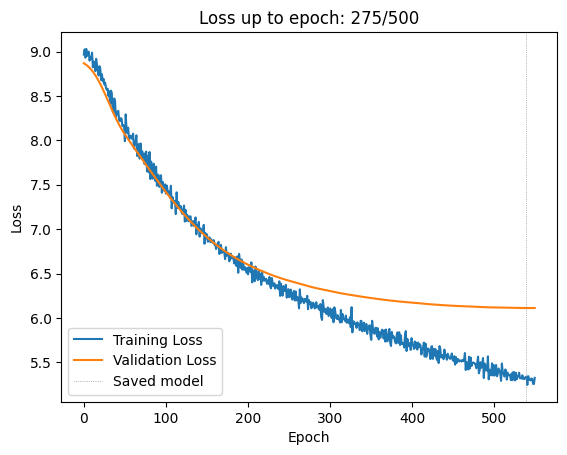

Epoch train loss: 5.324688911437988
Epoch valid loss: 6.111405372619629
Early stopped at epoch 274


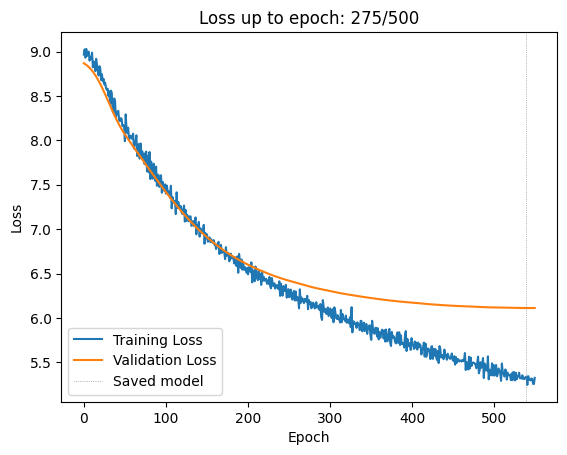

In [7]:
import train
# from importlib import reload
# reload(train)

n_epochs = 500
batch_logging_freq = 1

model = Model([x_dim, 64, n_classes], dropout=0.5)

trainer = train.Trainer(model, epochs=n_epochs, criterion=nn.CrossEntropyLoss(),
                  optim=torch.optim.Adam, lr=1e-3, stopping_batches=10,
                  batch_logging_freq = batch_logging_freq, use_cuda=False)
trainer.train(train_loader, valid_loader)

In [8]:
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    for X, y in iter(valid_loader):
        x = model.forward(X).numpy()
        auc = roc_auc_score(y.numpy(), x)
auc

0.87699130455262

In [11]:
import json

subm_ids = pd.read_csv('./data/dummy_submission_v1.csv')['projectID'].to_numpy()
with open('temp.tmp', 'r') as f:
    lut_ids = json.load(f)

missing_ids = [id for id in subm_ids if id not in lut_ids]


In [12]:
test_pickle = pd.read_pickle('./data/data_v1_test.pickle')
test_csv = pd.read_csv('./data/data_v1_test.csv')

In [25]:
result = {}
for id in missing_ids:
    res1 = test_pickle.loc[test_pickle.projectID==id, 'TFIDF']
    if len(res1) != 0:
        result[id] = list(res1)[0]
        continue

    res2 = test_csv.loc[test_csv.projectID==id, 'TFIDF']
    if len(res2) != 0:
        str_val = list(res2)[0]
        result[id] = [int(v) for v in str_val[1:-1].split(' ')]
        continue

with torch.no_grad():
    for id, tf in result.items():
        result[id] = torch.sigmoid(model.forward(torch.Tensor(tf))).numpy()

In [28]:
with open('LUT.csv', 'r') as f:
    lines = f.readlines()

with open('LUT_NN.csv', 'w+') as f:
    f.write(lines[0])
    for line in lines[1:]:
        id = int(line.split(',')[0])
        if id in result:
            f.write(str(id)+','+','.join([str(v) for v in result[id]])+'\n')
        else:
            f.write(line)

---

In [37]:
df_train_1 = pd.read_pickle('./data/data_v1_train.pickle')
df_train_2 = pd.read_csv('./data/data_v1_train.csv')

result = {}
for id in subm_ids:
    id = int(id)
    res1 = df_train_1.loc[df_train_1.projectID==id, 'TFIDF']
    if len(res1) != 0:
        result[id] = list(res1)[0]
        continue

    # res2 = df_train_2.loc[df_train_2.projectID==id, 'TFIDF']
    # if len(res2) != 0:
    #     str_val = list(res2)[0]
    #     result[id] = [int(v if v != '0.' else '0') for v in str_val[1:-1].split(' ')]
    #     continue
    
    res1 = test_pickle.loc[test_pickle.projectID==id, 'TFIDF']
    if len(res1) != 0:
        result[id] = list(res1)[0]
        continue

    res2 = test_csv.loc[test_csv.projectID==id, 'TFIDF']
    if len(res2) != 0:
        str_val = list(res2)[0]
        result[id] = [int(v) for v in str_val[1:-1].split(' ')]
        continue

In [38]:
with torch.no_grad():
    for id, tf in result.items():
        result[id] = torch.sigmoid(model.forward(torch.Tensor(tf))).numpy()

In [40]:
with open('NN.csv', 'w+') as f:
    f.write(lines[0])
    for id in result:
        f.write(str(id)+','+','.join([str(v) for v in result[id]])+'\n')